In [ ]:
%pip install selenium
%pip install beautifulsoup4
%pip install requests
%pip install xgboost

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import GridSearchCV

## Scraping data

In [11]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Base URL
base_url = 'https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/'

# List to store all the scraped data
all_listings = []

# Function to scrape data from a single page
def scrape_page(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    
    # Find all listing items
    items = soup.find_all('li', class_='chinh')
    
    listings = []
    
    for item in items:
        # Extract the title and link
        title_tag = item.find('a', title=True)
        title = title_tag['title'] if title_tag else None
        link = title_tag['href'] if title_tag else None
    
        # Extract the image URL
        image_tag = item.find('img', class_='lazy')
        image_url = image_tag['src'] if image_tag else None
    
        # Extract the area and price from the p tag
        p_tag = item.find('p')
        if p_tag:
            spans = p_tag.find_all('span')
            area = None
            price = None
            for span in spans:
                if 'Diện tích:' in span.text:
                    area = span.find('i').text.strip() if span.find('i') else None
                elif 'Giá:' in span.text:
                    price = span.find('i').text.strip() if span.find('i') else None
    
        # Extract the address
        address_tag = item.find('div', class_='address')
        address = address_tag.text.strip() if address_tag else None
    
        # Extract the description
        description_tag = item.find('div', class_='des_spec_bds')
        description = description_tag.text.strip() if description_tag else None
    
        # Extract the date
        date_tag = item.find('span', style=lambda x: x and 'color:' in x)
        date = date_tag.text.strip() if date_tag else None
    
        # Store the extracted data in a dictionary
        listing_data = {
            'Title': title,
            'Link': link,
            'Image URL': image_url,
            'Area': area,
            'Price': price,
            'Address': address,
            'Description': description,
            'Date': date
        }
    
        # Append the dictionary to the list of listings
        listings.append(listing_data)
    
    return listings

# Start URL
current_url = base_url

# Loop through pages
for _ in range(60):  # Limit to 100 pages or as needed
    print(f"Scraping: {current_url}")
    
    # Scrape the current page
    page_listings = scrape_page(current_url)
    all_listings.extend(page_listings)
    
    # Find the "next" page link
    r = requests.get(current_url)
    soup = BeautifulSoup(r.text, 'lxml')
    next_page_link = soup.find('a', rel='next')
    
    if next_page_link:
        current_url = next_page_link.get('href')
    else:
        break  # No more pages

# Create a DataFrame from the list of all listings
df = pd.DataFrame(all_listings)

# Print the DataFrame
df.shape

Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/
Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/page-2/
Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/page-3/
Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/page-4/
Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/page-5/
Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/page-6/
Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/page-7/
Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/page-8/
Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/page-9/
Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/page-10/
Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/page-11/
Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/page-12/
Scraping: https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duon

(1200, 8)

In [12]:
df.head()

,Title,Link,Image URL,Area,Price,Address,Description,Date
0,"Cần bán nền Tái Định Cư An Sơn, Thuận An Bình ...",https://www.batdongsanonline.vn/Can-ban-nen-Ta...,https://www.batdongsanonline.vn/image/catalog/...,100 m²,2.25 Tỷ,"Thuận An, Bình Dương","tổng diện tích: 100m2 full thổ cư, ngang 5mx20...",08/07/2024
1,BÁN 420M2 ĐẤT NGAY KHU ĐỘ THỊ &CÔNG NGHIỆP DÂN...,https://www.batdongsanonline.vn/BAN-420M2-DAT-...,https://www.batdongsanonline.vn/image/catalog/...,420 m²,1.25 Tỷ,"Bến Cát, Bình Dương",- chính chủ cần bán 400m2 đất ngay khu đô thị ...,6 giờ trước
2,168M2-HAI MT TRƯỚC SAU- SÁT ĐƯỜNG NGUYỄN HỮU C...,https://www.batdongsanonline.vn/168M2-HAI-MT-T...,https://www.batdongsanonline.vn/image/catalog/...,168 m²,1.5 Tỷ,"Thuận An, Bình Dương","chính chủ cần sang gấp 3 lô đất liền kề ,2mt t...",6 giờ trước
3,"CHÍNH CHỦ CẦN BÁN NHÀ MT ĐƯỜNG NHỰA,SHR-VĨNH P...",https://www.batdongsanonline.vn/CHINH-CHU-CAN-...,https://www.batdongsanonline.vn/image/catalog/...,75 m²,3.25 Tỷ,"Thuận An, Bình Dương",chính chủ trực tiếp bán căn nhà mặt tiền đượng...,6 giờ trước
4,KINH DOANH THUA LỖ-SANG GẤP 173M2-GÓC 2 MẶT TI...,https://www.batdongsanonline.vn/KINH-DOANH-THU...,https://www.batdongsanonline.vn/image/catalog/...,173 m²,1.92 Tỷ,"Thuận An, Bình Dương","do kinh tế khó khăn ,kinh doanh thua lỗ cần ti...",6 giờ trước


**On the website, every property has its own direct link that lead to the page showcasing more detail, I continue scraping those direct urls for more information**

In [13]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Function to scrape additional information from detailed page
def scrape_details(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')

    # Extract the title
    title_tag = soup.find('h1', class_='title_D')
    title = title_tag.text.strip() if title_tag else None

    # Extract the detailed information
    details = {
        'Title': title,
        'Chiều ngang': None,
        'Chiều dài': None,
        'Đường trước đất': None,
        'Pháp lý': None,
        'Tình trạng': None,
        'Đường': None,
        'Diện tích thổ cư': None,
        'Đặc điểm nổi bật': None
    }

    # Find the list of details
    detail_list = soup.find('ul', class_='listTienich')
    if detail_list:
        items = detail_list.find_all('li')
        for item in items:
            span_tag = item.find('span')
            div_tag = item.find('div', class_='text-right fr')
            
            # Safely extract text and value
            text = span_tag.text.strip() if span_tag else None
            value = div_tag.text.strip() if div_tag else None

            # Check if text is not None before using it
            if text:
                if 'Chiều ngang' in text:
                    details['Chiều ngang'] = value
                elif 'Chiều dài' in text:
                    details['Chiều dài'] = value
                elif 'Đường trước đất' in text:
                    details['Đường trước đất'] = value
                elif 'Pháp lý' in text:
                    details['Pháp lý'] = value
                elif 'Tình trạng' in text:
                    details['Tình trạng'] = value
                elif 'Đường' in text:
                    details['Đường'] = value
                elif 'Diện tích thổ cư' in text:
                    details['Diện tích thổ cư'] = value
                elif 'Đặc điểm nổi bật' in text:
                    details['Đặc điểm nổi bật'] = value

    return details

# Example DataFrame structure
data = df[['Title', 'Link']]

# List to store additional details
additional_details = []

# Iterate through each link in the DataFrame
for index, row in data.iterrows():
    url = row['Link']
    details = scrape_details(url)
    additional_details.append(details)

# Convert additional details to DataFrame
details_df = pd.DataFrame(additional_details)

# Combine with the original DataFrame
# df_combined = pd.concat([data, details_df], axis=1)

# print(df_combined)
details_df.head()

,Title,Chiều ngang,Chiều dài,Đường trước đất,Pháp lý,Tình trạng,Đường,Diện tích thổ cư,Đặc điểm nổi bật
0,"Cần Bán Nền Tái Định Cư An Sơn, Thuận An Bình ...",5m,20m,7m,Sổ hồng sẵn,Đất trống,Bê tông,100m2,Mua chính chủ
1,BÁN 420M2 ĐẤT NGAY KHU ĐỘ THỊ &CÔNG NGHIỆP DÂN...,14m,30m,12m,Sổ hồng sẵn,Đất trống,Nhựa,420m2,Mua chính chủCó xe đưa đón đi xem đấtGiá rẻĐất...
2,168M2-HAI MT TRƯỚC SAU- SÁT ĐƯỜNG NGUYỄN HỮU C...,14m,13m,8m,Sổ hồng sẵn,Đất trống,Bê tông,168m2,Mua chính chủGiá rẻĐất 2 mặt tiền
3,"CHÍNH CHỦ CẦN BÁN NHÀ MT ĐƯỜNG NHỰA,SHR-VĨNH P...",5m,15m,8m,Sổ hồng sẵn,Đất có sẵn nhà,Nhựa,75m2,Mua chính chủGiá rẻ
4,KINH DOANH THUA LỖ-SANG GẤP 173M2-GÓC 2 MẶT TI...,18m,10m,8m,Sổ hồng sẵn,Đất trống,Nhựa,140m2,Mua chính chủGiá rẻĐất 2 mặt tiền


In [14]:
details_df.to_csv(r"D:\PTDLKD\SCRAPING DATA\detail.csv", index = False)

In [15]:
detail = details_df.reset_index()
dfr = df.reset_index()

In [16]:
cp_data = dfr.merge(detail, on = 'index', how = 'inner')
cp_data = cp_data.drop(columns = ['Link', 'Image URL', 'index', 'Title_y'])
cp_data = cp_data.rename(columns={'Title_x': 'Title'})
cp_data.to_csv(r"D:\PTDLKD\SCRAPING DATA\datedt.csv", index = False)
cp_data = cp_data.drop(columns = ['Date'])

**The title of the property change after going to the direct url thus I merge using index and obtain the dataset as follows:**

In [17]:
cp_data.head()

,Title,Area,Price,Address,Description,Chiều ngang,Chiều dài,Đường trước đất,Pháp lý,Tình trạng,Đường,Diện tích thổ cư,Đặc điểm nổi bật
0,"Cần bán nền Tái Định Cư An Sơn, Thuận An Bình ...",100 m²,2.25 Tỷ,"Thuận An, Bình Dương","tổng diện tích: 100m2 full thổ cư, ngang 5mx20...",5m,20m,7m,Sổ hồng sẵn,Đất trống,Bê tông,100m2,Mua chính chủ
1,BÁN 420M2 ĐẤT NGAY KHU ĐỘ THỊ &CÔNG NGHIỆP DÂN...,420 m²,1.25 Tỷ,"Bến Cát, Bình Dương",- chính chủ cần bán 400m2 đất ngay khu đô thị ...,14m,30m,12m,Sổ hồng sẵn,Đất trống,Nhựa,420m2,Mua chính chủCó xe đưa đón đi xem đấtGiá rẻĐất...
2,168M2-HAI MT TRƯỚC SAU- SÁT ĐƯỜNG NGUYỄN HỮU C...,168 m²,1.5 Tỷ,"Thuận An, Bình Dương","chính chủ cần sang gấp 3 lô đất liền kề ,2mt t...",14m,13m,8m,Sổ hồng sẵn,Đất trống,Bê tông,168m2,Mua chính chủGiá rẻĐất 2 mặt tiền
3,"CHÍNH CHỦ CẦN BÁN NHÀ MT ĐƯỜNG NHỰA,SHR-VĨNH P...",75 m²,3.25 Tỷ,"Thuận An, Bình Dương",chính chủ trực tiếp bán căn nhà mặt tiền đượng...,5m,15m,8m,Sổ hồng sẵn,Đất có sẵn nhà,Nhựa,75m2,Mua chính chủGiá rẻ
4,KINH DOANH THUA LỖ-SANG GẤP 173M2-GÓC 2 MẶT TI...,173 m²,1.92 Tỷ,"Thuận An, Bình Dương","do kinh tế khó khăn ,kinh doanh thua lỗ cần ti...",18m,10m,8m,Sổ hồng sẵn,Đất trống,Nhựa,140m2,Mua chính chủGiá rẻĐất 2 mặt tiền


In [18]:
# Replace non-numeric characters and empty strings, and convert to float
cp_data[['Chiều ngang', 'Chiều dài', 'Đường trước đất']] = (
    cp_data[['Chiều ngang', 'Chiều dài', 'Đường trước đất']]
    .replace({'m': '', 'q': '', 'gànga': '', 'NE3': '',',': '.'}, regex=True)  # Remove non-numeric characters
    .apply(lambda x: x.str.strip())  # Strip any leading/trailing whitespace
    .replace('', np.nan)  # Replace empty strings with NaN
    .astype(float)  # Convert to float
)
# Remove "Bình Dương" from the 'location' column
cp_data['Address'] = cp_data['Address'].str.replace(', Bình Dương', '').str.strip()
# Function to extract numeric values
def extract_numeric(value):
    if isinstance(value, str):
        value = value.replace('m²', '').replace('m2', '').replace(',', '').strip()
    return pd.to_numeric(value, errors='coerce')
# Apply the conversion function to the DataFrame columns
cp_data['Area'] = cp_data['Area'].apply(extract_numeric)
cp_data['Diện tích thổ cư'] = cp_data['Diện tích thổ cư'].apply(extract_numeric)
cp_data['Area_r']= cp_data['Chiều dài']*cp_data['Chiều ngang']

In [19]:
import pandas as pd
import numpy as np

# Function to convert price strings to numeric values
def convert_price(row):
    price_str = row['Price']
    area = row['Area_r']
    
    if pd.isnull(price_str):
        return np.nan

    # Remove any commas and whitespace
    price_str = price_str.replace(',', '').strip()

    # Dictionary to map units to their respective multipliers
    unit_multipliers = {
        'Tỷ': 1e9,            # Billion
        'Triệu': 1e6,         # Million
        'Triệu/m2': 1e6,      # Million per square meter
        'Thỏa thuận': np.nan  # Special case for agreements
    }
# Return NaN for 'Triệu/Tháng'
    if 'Triệu/Tháng' in price_str:
        return np.nan

    # Extract numeric value and unit
    for unit, multiplier in unit_multipliers.items():
        if unit in price_str:
            if unit == 'Triệu/Tháng':
                    return np.nan
            # Split numeric part and unit
            num_str = price_str.split(unit)[0].strip()
            try:
                # Convert numeric part to float
                num_value = float(num_str)
                if unit == 'Tỷ':
                    if num_value > 20 and num_value < 100:
                        return num_value * 1e7
                    elif num_value > 100 and num_value < 1000:
                        # User might have used "Tỷ" instead of "Triệu"
                        return num_value * 1e6
                    elif num_value >= 1000:
                        # Correct for values larger than 1,000 tỷ
                        return num_value * 1e6 
                    else:
                        return num_value * multiplier
                
                elif unit == 'Triệu':
                    if num_value <100:
                        return np.nan
                    else:
                        return num_value * multiplier

                # Handle special case for 'Triệu/m2' by multiplying with area
                if unit == 'Triệu/m2' and area is not None:
                    return num_value * multiplier * area
                
                return num_value * multiplier
            except ValueError:
                return np.nan

    # Handle any cases not covered by the unit multipliers
    try:
        # If no unit is found, assume the value is in millions
        return float(price_str) * 1e6
    except ValueError:
        return np.nan

# Apply conversion function and replace the 'price' column
cp_data['Price'] = cp_data.apply(convert_price, axis=1)
cp_data = cp_data[~((cp_data['Title'].isin(['Chủ Kẹt Tiền Cần Bán Nhanh Lô Đất 300m2 Tại KĐT Mới Bình Dương - T/Cư 100%,Ngay TT Hành Chính',
       'Chính chủ cần bán lô đất 150m2, 7.5x20, thổ cư, ngay chợ dân sinh',
       'Chỉ 15%  Sở Hữu Đất Mặt Tiền Trục Thương Mại 17m Tại Bàu Bàng',
       'Cắt lỗ lô đất dự án Nam An New City Bàu Bàng',
       'Cần bán gấp lô đất full thổ cư Bàu Bàng Bình Dương',
       'Cần bán lô đất mặt tiền đường 17m đối diện trường THCS tại Bàu Bàng 1ty550/100m2',
       'Chính Chủ bán lô đất trong khu công nghiệp Bàu Bàng, mt đường 17m.',
       'Chính chủ bán lô đất nam an bàu bàng giá 1ty550',
       'Cần tiền làm ăn , cần BÁN GẤP , ai quan tâm liên hẹ trực tiếp sđt 0379335142',
       'Dự án siêu rẻ ở Bình Dương cực hottt',
       'Ngân hàng dí lắm rồi nên cần bán gấp lô góc 2 MT 450m2 (18x25m), đối diện chợ, ngay KCN Việt Sing']))&(cp_data['Price'] >1e10))]

**Description:**

The website has several data entry issues with user inputs. After checking the website batdongsanonline.com, I identified several common data entry errors that need to be addressed as follows:

- Users entering incorrect real estate prices:
  + Forgetting to enter a comma in decimal numbers, leading to real estate prices being displayed in the trillions of VND when they are actually only worth a few billion VND. This results in properties that should be priced in the billions of VND being displayed as tens of billions due to the missing decimal point. However, the dataset still contains properties that are genuinely worth tens of billions of VND, so I filtered these for analysis.
  + Entering the wrong price unit, where users mistakenly enter "Tỷ" (billion) instead of "Triệu" (million), causing real estate prices to be in the hundreds of billions of VND.
  + Displaying rental prices in "Triệu/Tháng" (million/month). Since the dataset is used for analyzing real estate sale prices, I excluded these values.
  + Displaying prices calculated per square meter with the unit "Triệu/m2" (million/m²). I have multiplied these values by the area to obtain the total real estate price. 
- Users input wrong Area information, I change Area into Length x Width


In [20]:
cp_data = cp_data.drop_duplicates()

In [21]:
cp_data.isnull().sum()

Title                 0
Area                  1
Price               118
Address               0
Description           0
Chiều ngang         660
Chiều dài           666
Đường trước đất     723
Pháp lý             654
Tình trạng          708
Đường               722
Diện tích thổ cư    762
Đặc điểm nổi bật    654
Area_r              666
dtype: int64

- There are many null data thus I remove the those data points as some missing the dimension data (Length, Width) which are used to calculate the real area of the property.

In [22]:
cp_data = cp_data.dropna()

In [ ]:
cp_data.to_csv(r"D:\PTDLKD\SCRAPING DATA\data.csv", index= False)

## Part I: EDA

### Data description

- After all, I obtain the dataset as follows:

In [24]:
cp_data.head()

,Title,Area,Price,Address,Description,Chiều ngang,Chiều dài,Đường trước đất,Pháp lý,Tình trạng,Đường,Diện tích thổ cư,Đặc điểm nổi bật,Area_r
0,"Cần bán nền Tái Định Cư An Sơn, Thuận An Bình ...",100.0,2.250000e+09,Thuận An,"tổng diện tích: 100m2 full thổ cư, ngang 5mx20...",5.0,20.0,7.0,Sổ hồng sẵn,Đất trống,Bê tông,100.0,Mua chính chủ,100.0
1,BÁN 420M2 ĐẤT NGAY KHU ĐỘ THỊ &CÔNG NGHIỆP DÂN...,420.0,1.250000e+09,Bến Cát,- chính chủ cần bán 400m2 đất ngay khu đô thị ...,14.0,30.0,12.0,Sổ hồng sẵn,Đất trống,Nhựa,420.0,Mua chính chủCó xe đưa đón đi xem đấtGiá rẻĐất...,420.0
2,168M2-HAI MT TRƯỚC SAU- SÁT ĐƯỜNG NGUYỄN HỮU C...,168.0,1.500000e+09,Thuận An,"chính chủ cần sang gấp 3 lô đất liền kề ,2mt t...",14.0,13.0,8.0,Sổ hồng sẵn,Đất trống,Bê tông,168.0,Mua chính chủGiá rẻĐất 2 mặt tiền,182.0
3,"CHÍNH CHỦ CẦN BÁN NHÀ MT ĐƯỜNG NHỰA,SHR-VĨNH P...",75.0,3.250000e+09,Thuận An,chính chủ trực tiếp bán căn nhà mặt tiền đượng...,5.0,15.0,8.0,Sổ hồng sẵn,Đất có sẵn nhà,Nhựa,75.0,Mua chính chủGiá rẻ,75.0
4,KINH DOANH THUA LỖ-SANG GẤP 173M2-GÓC 2 MẶT TI...,173.0,1.920000e+09,Thuận An,"do kinh tế khó khăn ,kinh doanh thua lỗ cần ti...",18.0,10.0,8.0,Sổ hồng sẵn,Đất trống,Nhựa,140.0,Mua chính chủGiá rẻĐất 2 mặt tiền,180.0


In [ ]:
import pandas as pd
import numpy as np
cp_data = pd.read_csv('D:\PTDLKD\SCRAPING DATA\data.csv')


### Summary of numerical data

In [4]:
cp_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,272.0,3.351276e+02,8.316636e+02,40.0,1.000000e+02,1.400000e+02,3.092500e+02,1.110600e+04
Price,272.0,1.700544e+09,1.775857e+09,220000000.0,8.362500e+08,1.300000e+09,1.550000e+09,9.900000e+09
Chiều ngang,272.0,9.625625e+00,2.477260e+01,4.0,5.000000e+00,5.000000e+00,1.000000e+01,4.050000e+02
Chiều dài,272.0,2.630813e+01,1.937389e+01,10.0,1.900000e+01,2.000000e+01,3.000000e+01,2.600000e+02
Đường trước đất,272.0,1.350000e+01,5.260554e+00,2.0,8.000000e+00,1.500000e+01,1.700000e+01,3.200000e+01
Diện tích thổ cư,272.0,1.762500e+02,1.664353e+02,19.3,8.875000e+01,1.000000e+02,2.000000e+02,1.427000e+03
Area_r,272.0,2.779273e+02,7.493213e+02,50.0,1.000000e+02,1.000000e+02,2.955000e+02,1.093500e+04


**Comment:** The information that can be extracted from the website is mostly dimension information

### Summary of categorical data data

In [5]:
cp_data.select_dtypes('object').describe().T

,count,unique,top,freq
Title,272,269,"Đất nền Bàu Bàng, SHR , Cạnh TTHC giá chỉ 1,55...",2
Address,272,9,Bàu Bàng,81
Description,272,248,"???? nằm ngay khu dân cư hiện hữu, liền kề quố...",4
Pháp lý,272,3,Sổ hồng sẵn,264
Tình trạng,272,3,Đất trống,240
Đường,272,5,Nhựa,229
Đặc điểm nổi bật,272,13,Mua chính chủCó xe đưa đón đi xem đấtGiá rẻĐất...,67


**Comment:** In Binh Duong, the busiest area for real estate market is Bau Bang 

### Outliers analysis

In [6]:
dt_tu = cp_data.drop(columns=['Title','Area'])

Text(0, 0.5, 'Values')

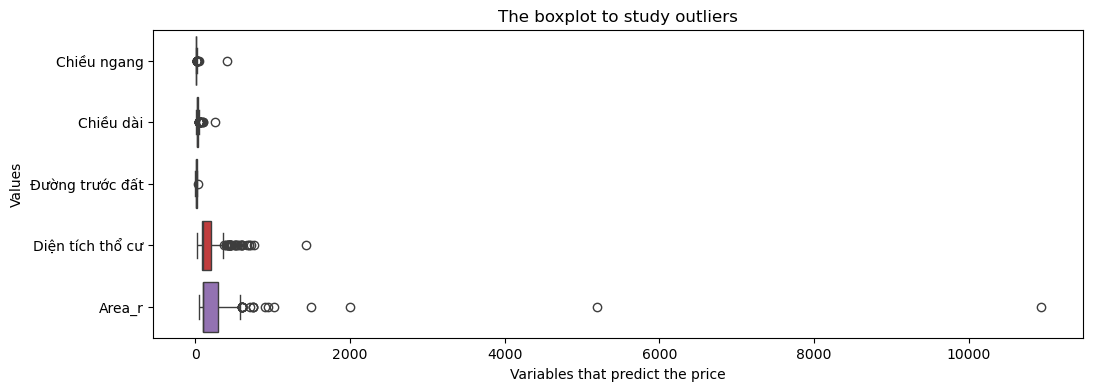

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,4))
sns.boxplot(data=dt_tu.drop(columns='Price'), orient='h')
plt.title('The boxplot to study outliers')
plt.xlabel('Variables that predict the price')
plt.ylabel('Values')

Only 3 properties have the Area above 2000 m2, thus can be considered outliers, thus I remove it and obtain:

In [10]:
dt_tu = dt_tu[dt_tu['Area_r']<2000.0]

Text(0, 0.5, 'Values')

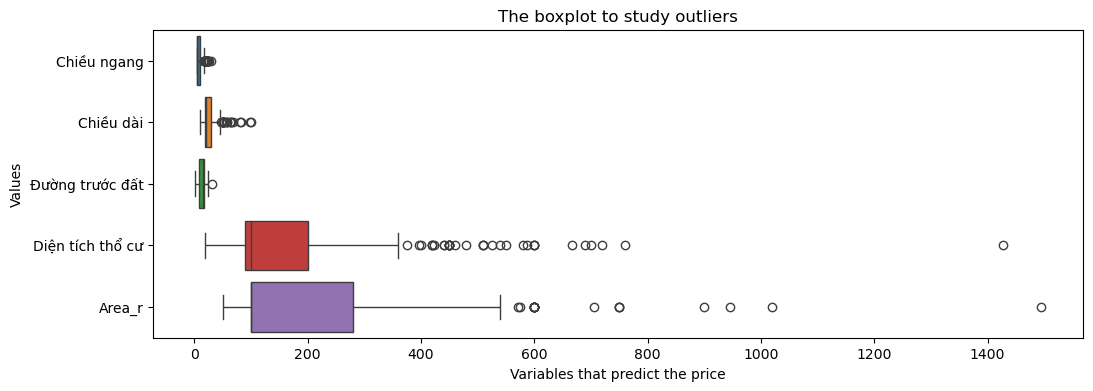

In [11]:
plt.figure(figsize=(12,4))
sns.boxplot(data=dt_tu.drop(columns='Price'), orient='h')
plt.title('The boxplot to study outliers')
plt.xlabel('Variables that predict the price')
plt.ylabel('Values')

### Price description

<Axes: xlabel='Price'>

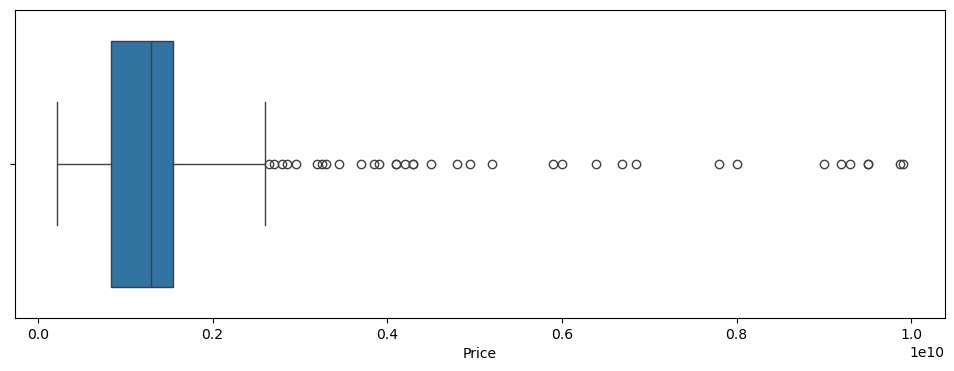

In [12]:
plt.figure(figsize=(12,4))
sns.boxplot(data=dt_tu['Price'], orient='h')

**Comment:** Too many outliers but the price of a property maybe skewed by seasonal factors and geometric factors, thus I keep the dataset as it is

### Data to use information

In [34]:
dt_tu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 0 to 271
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     268 non-null    float64
 1   Address                   268 non-null    object 
 2   Description               268 non-null    object 
 3   Chiều ngang               268 non-null    float64
 4   Chiều dài                 268 non-null    float64
 5   Đường trước đất           268 non-null    float64
 6   Pháp lý                   268 non-null    object 
 7   Tình trạng                268 non-null    object 
 8   Đường                     268 non-null    object 
 9   Diện tích thổ cư          268 non-null    float64
 10  Đặc điểm nổi bật          268 non-null    object 
 11  Area_r                    268 non-null    float64
 12  Mua chính chủ             268 non-null    int64  
 13  Có xe đưa đón đi xem đất  268 non-null    int64  
 14  Giá rẻ         

### Correlation analysis

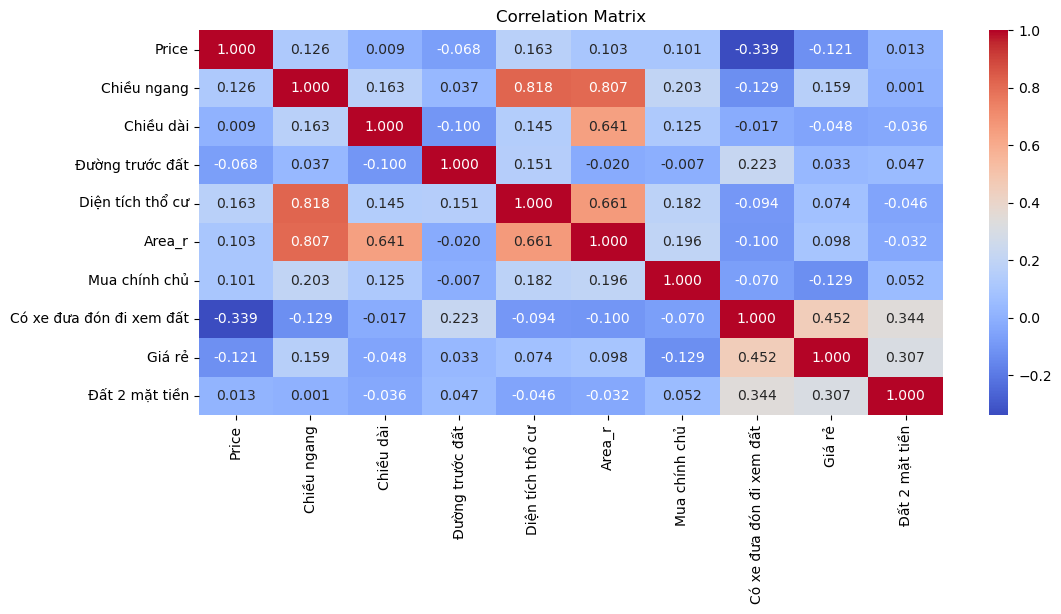

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.heatmap(dt_tu.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Matrix')
plt.show()

**Comment:** The correlation between the target feature: Price and other features is rather low, which indicate the there are other factors that actually drive the price of a property. The factors may include:
- Economic factors: Economic situation, FDIs, policies that affect the Law on Real Estate, economic events,...
- Geographical factors: nearby locations, center of the province,...
- Population density of the property's location

### Univariate Analysis

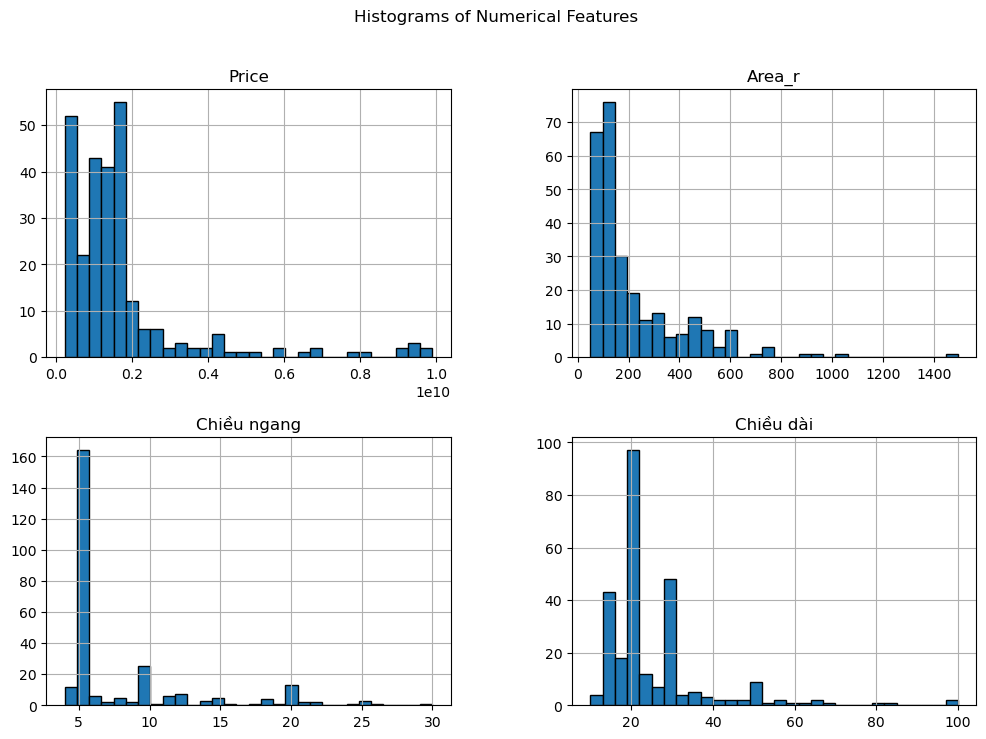

In [36]:
dt_tu[['Price', 'Area_r', 'Chiều ngang', 'Chiều dài']].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.show()

**Comment:** Price has a strange pattern of fluctuation

### Bivariate Analysis

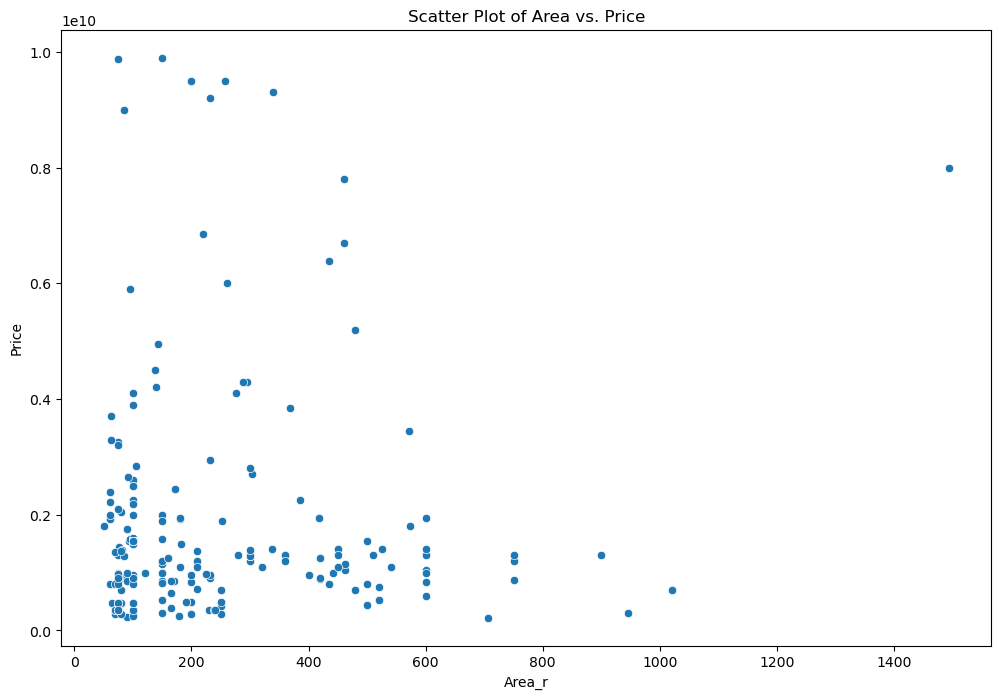

In [37]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Area_r', y='Price', data=dt_tu)
plt.title('Scatter Plot of Area vs. Price')
plt.show()

**Comment:** The scatter plot indicates the weak relationship between Area and Price 

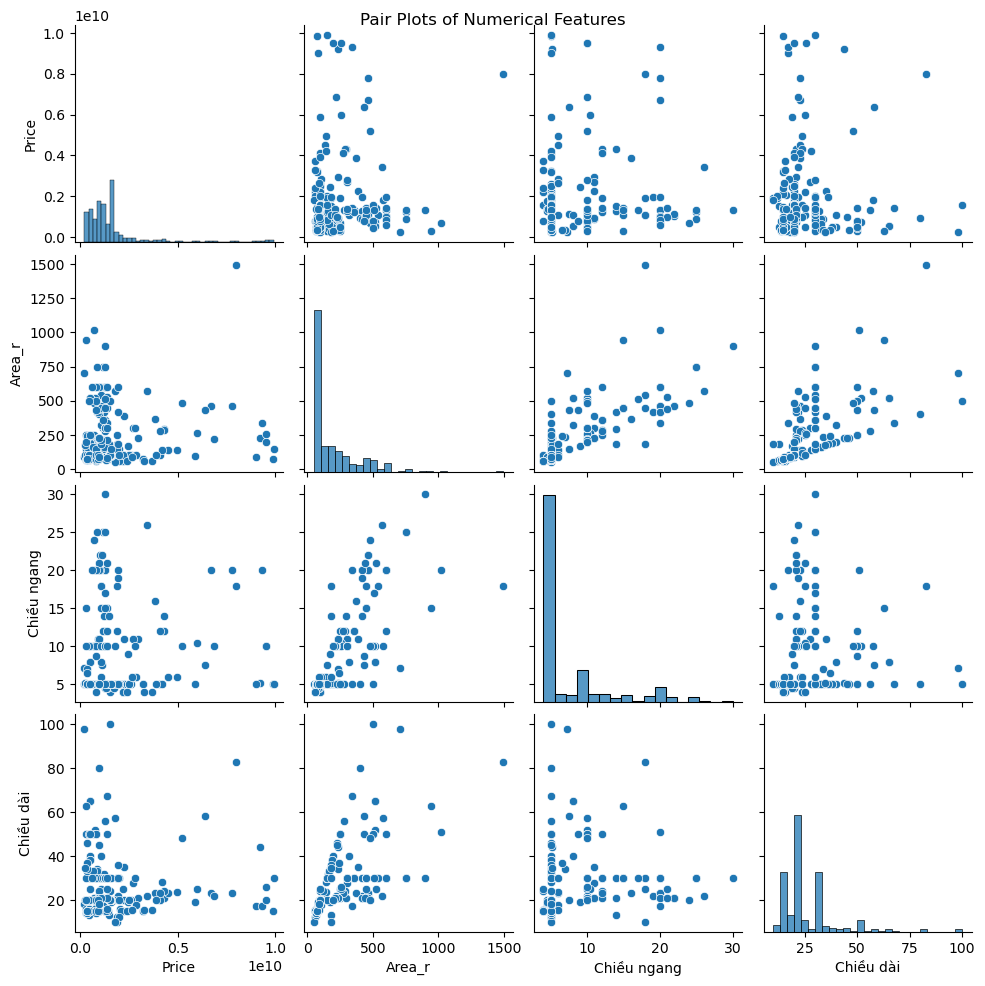

In [38]:
sns.pairplot(dt_tu[['Price', 'Area_r', 'Chiều ngang', 'Chiều dài']])
plt.suptitle('Pair Plots of Numerical Features')
plt.show()

**Comment:**
- Price has weak relationship with other numerical features
- Area has a recognizable relationship with dimensions data (Length and Width)

### Categorical features data description

In [13]:
#Check the unique values:
list_obj = dt_tu.drop(columns=[ 'Description']).loc[:, dt_tu.dtypes == object].columns.tolist()
for j in list_obj:
  print(f"Unique values of {j}: {dt_tu[j].unique()}")

Unique values of Address: ['Thuận An' 'Bến Cát' 'Dầu Tiếng' 'Thủ Dầu Một' 'Bàu Bàng' 'Dĩ An'
 'Phú Giáo' 'Bắc Tân Uyên' 'Tân Uyên']
Unique values of Pháp lý: ['Sổ hồng sẵn' 'Đang chờ sổ' 'Hợp đồng mua bán']
Unique values of Tình trạng: ['Đất trống' 'Đất có sẵn nhà' 'Đất có cây ăn trái']
Unique values of Đường: ['Bê tông' 'Nhựa' '10m' 'Đá cấp khối' 'Đất']
Unique values of Đặc điểm nổi bật: ['Mua chính chủ'
 'Mua chính chủCó xe đưa đón đi xem đấtGiá rẻĐất 2 mặt tiền'
 'Mua chính chủGiá rẻĐất 2 mặt tiền' 'Mua chính chủGiá rẻ'
 'Mua chính chủĐất 2 mặt tiền'
 'Mua chính chủCó xe đưa đón đi xem đấtGiá rẻ' 'Giá rẻ'
 'Có xe đưa đón đi xem đấtGiá rẻ'
 'Có xe đưa đón đi xem đấtGiá rẻĐất 2 mặt tiền'
 'Mua chính chủCó xe đưa đón đi xem đất' 'Giá rẻĐất 2 mặt tiền'
 'Có xe đưa đón đi xem đất' 'Đất 2 mặt tiền']


- The information in Đặc điểm nổi bật may be selected from a drop down menu thus I encode the column 
- The information 10m in Đường does not represent a type of material for the street thus can be considered outlier

**Visualizations for identifying patterns on relationship between categorical features with price**

In [14]:
# Define the features to one-hot encode
features = ['Mua chính chủ', 'Có xe đưa đón đi xem đất', 'Giá rẻ', 'Đất 2 mặt tiền']

# Create a function to check for the presence of each feature
for feature in features:
    dt_tu[feature] = dt_tu['Đặc điểm nổi bật'].apply(lambda x: 1 if feature in x else 0)
dt_tu = dt_tu[~(dt_tu['Đường']=='10m')]

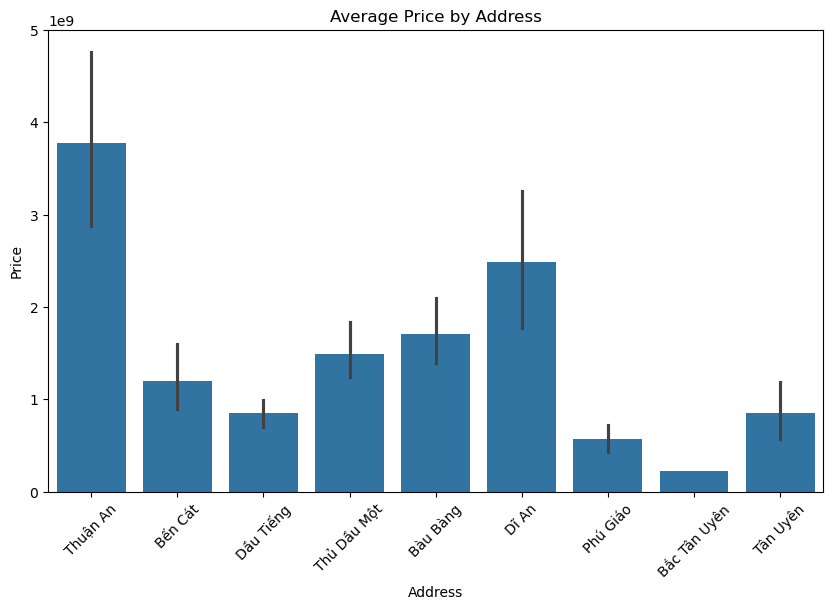

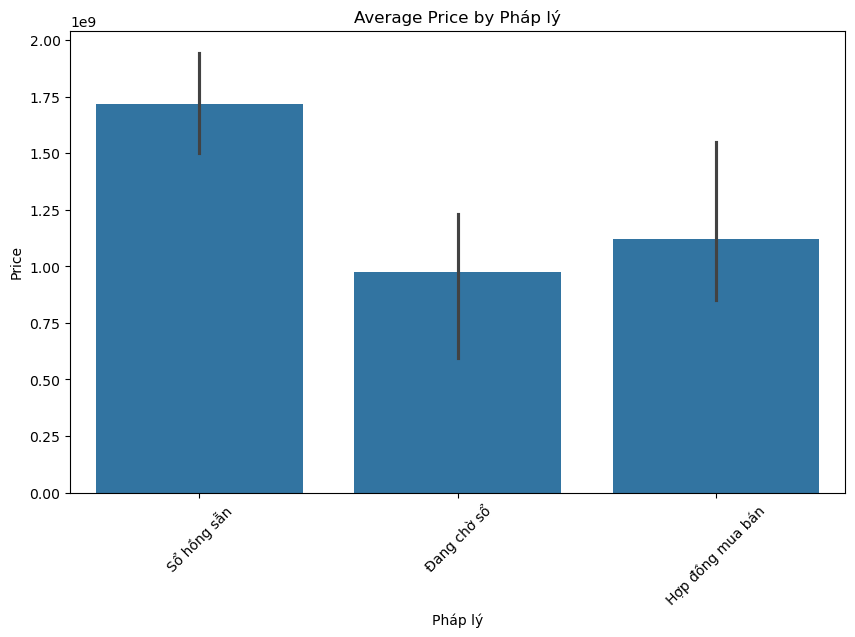

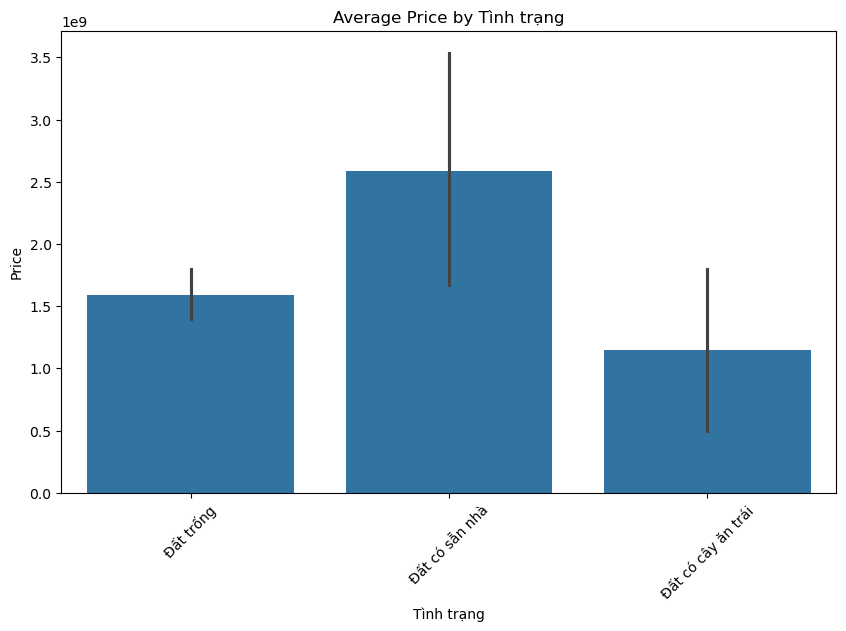

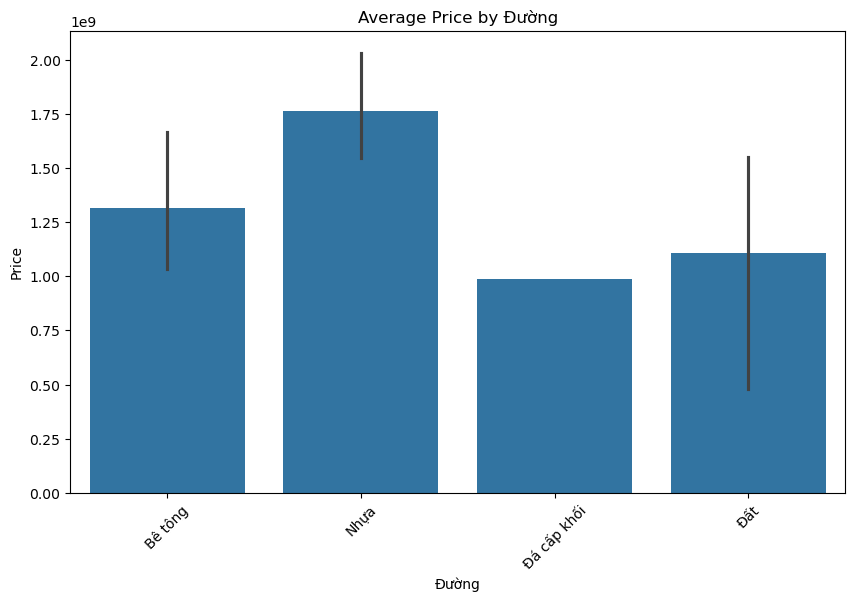

In [15]:
categorical_vars = ['Address', 'Pháp lý', 'Tình trạng', 'Đường']

for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=var, y='Price', data=dt_tu)
    plt.title(f'Average Price by {var}')
    plt.xticks(rotation=45)
    plt.show()

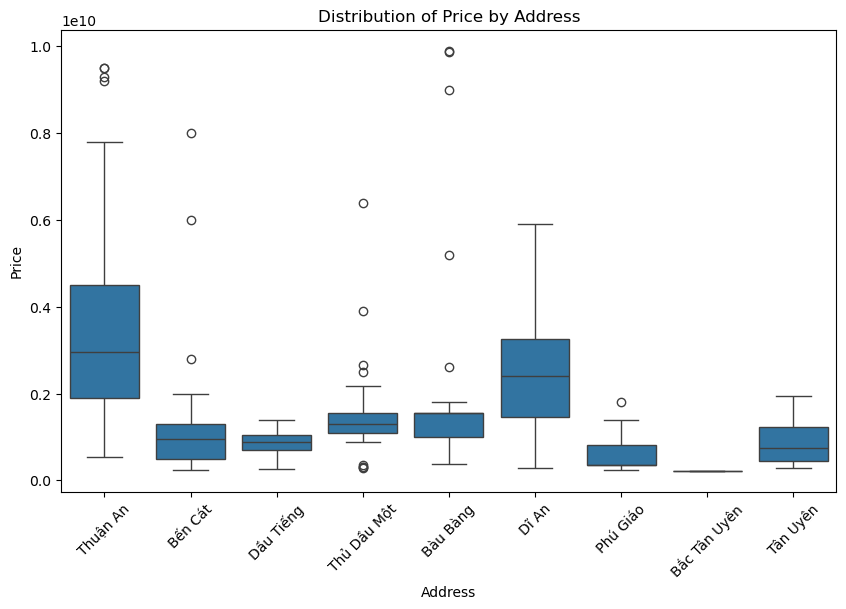

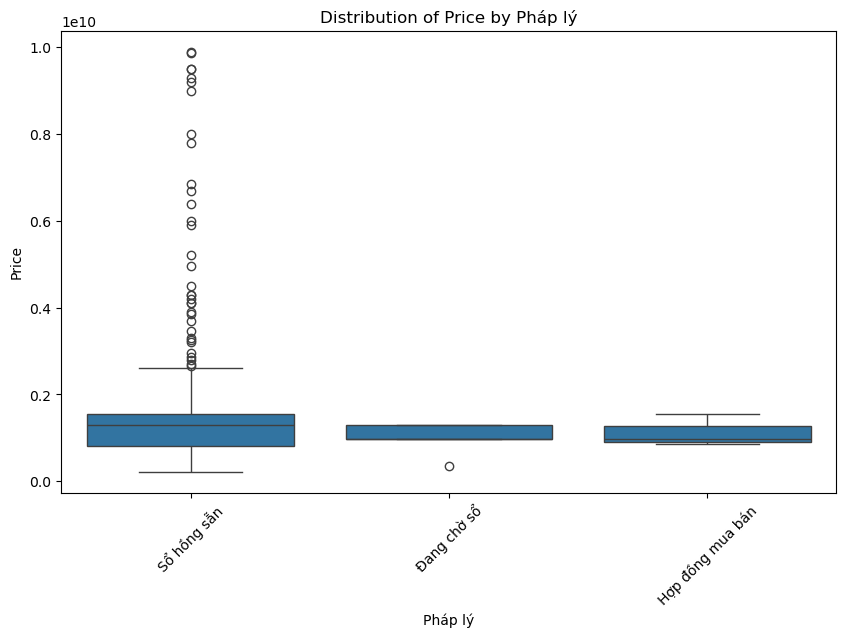

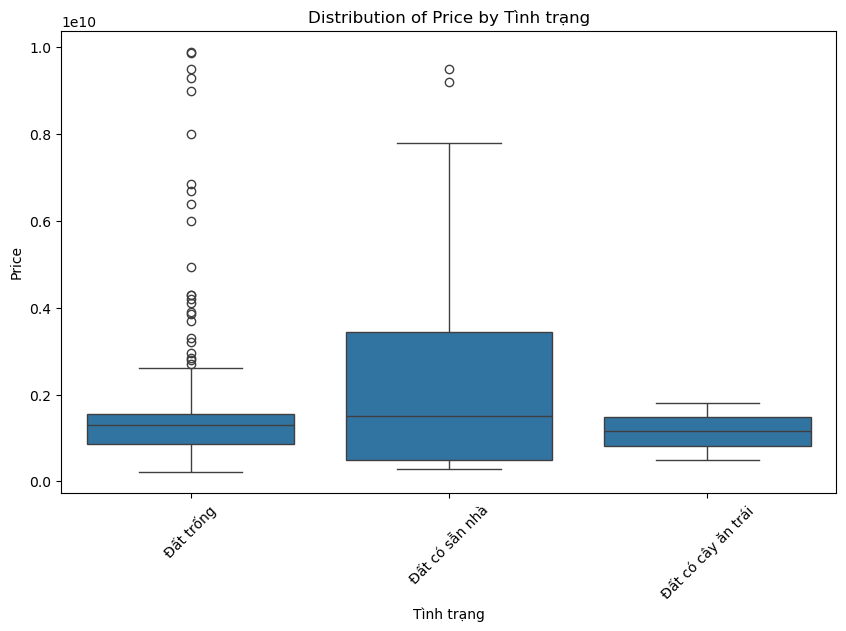

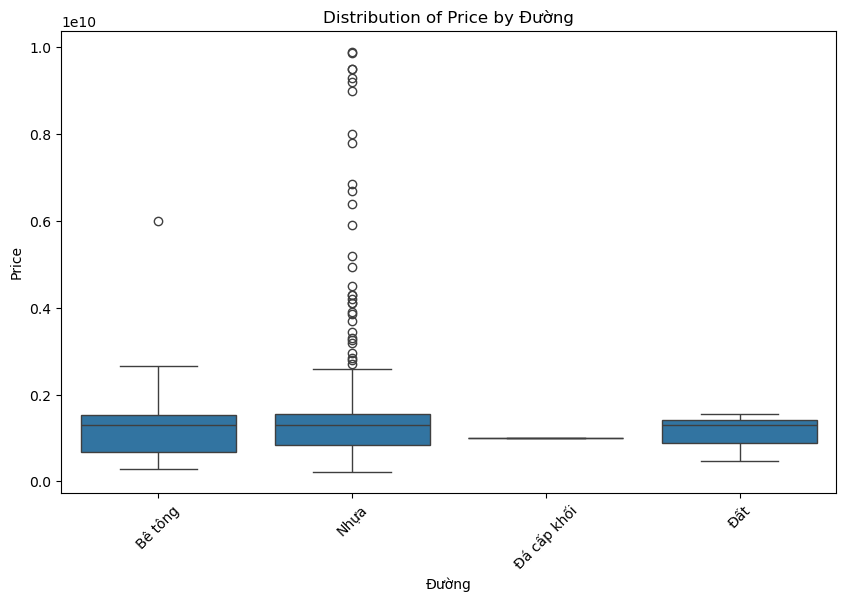

In [40]:
for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=var, y='Price', data=dt_tu)
    plt.title(f'Distribution of Price by {var}')
    plt.xticks(rotation=45)
    plt.show()


Properties with a ready **"Sổ hồng"** (Land Use Rights Certificate), existing buildings, and paved roads tend to have higher prices.

## Machine Learning model to identify important factors that affect price

Price is the target variable
I one hot ecoding the other features and obtain:

In [41]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.preprocessing import LabelEncoder
X = dt_tu.drop(["Price", "Đặc điểm nổi bật", 'Description'], axis=1)
y = dt_tu["Price"]
X = pd.get_dummies(X, dtype=int)
# Kiểm tra kết quả
X.head()

,Chiều ngang,Chiều dài,Đường trước đất,Diện tích thổ cư,Area_r,Mua chính chủ,Có xe đưa đón đi xem đất,Giá rẻ,Đất 2 mặt tiền,Address_Bàu Bàng,...,Pháp lý_Hợp đồng mua bán,Pháp lý_Sổ hồng sẵn,Pháp lý_Đang chờ sổ,Tình trạng_Đất có cây ăn trái,Tình trạng_Đất có sẵn nhà,Tình trạng_Đất trống,Đường_Bê tông,Đường_Nhựa,Đường_Đá cấp khối,Đường_Đất
0,5.0,20.0,7.0,100.0,100.0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
1,14.0,30.0,12.0,420.0,420.0,1,1,1,1,0,...,0,1,0,0,0,1,0,1,0,0
2,14.0,13.0,8.0,168.0,182.0,1,0,1,1,0,...,0,1,0,0,0,1,1,0,0,0
3,5.0,15.0,8.0,75.0,75.0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
4,18.0,10.0,8.0,140.0,180.0,1,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0


In [42]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành train và test (70% train, 30% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Chia tiếp dữ liệu tạm thời thành validate và test (50% của 30% còn lại)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3333, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regressor': SVR(),
    'XGBoost': xgb.XGBRegressor()
}

# Define parameter grids for each model
param_grids = {
    'Linear Regression': {},
    'Random Forest': {
        'n_estimators': [50, 100, 150, 200, 250],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'max_depth': [3, 5, 7]
    },
    'Support Vector Regressor': {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.2]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 10]
    }
}


I compare many models for regression and obtain the result as follows:

In [45]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through models and their parameter grids
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled_df, y_train)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val_scaled_df)
    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    # Store results
    results[name] = {
        'Best Params': best_params,
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

# Print results
for name, metrics in results.items():
    print(f"\n{name} Results:")
    print(f"Best Params: {metrics['Best Params']}")
    print(f"Mean Squared Error: {metrics['MSE']}")
    print(f"Mean Absolute Error: {metrics['MAE']}")
    print(f"R-squared: {metrics['R2']}")


Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Regressor...
Training XGBoost...

Linear Regression Results:
Best Params: {}
Mean Squared Error: 2.6291260389424143e+18
Mean Absolute Error: 1028542253.0808388
R-squared: 0.16265595431783864

Random Forest Results:
Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Mean Squared Error: 2.3471773594105206e+18
Mean Absolute Error: 952990238.9607989
R-squared: 0.2524531129542301

Gradient Boosting Results:
Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Mean Squared Error: 2.7406805915022874e+18
Mean Absolute Error: 950241876.3909727
R-squared: 0.1271272124579308

Support Vector Regressor Results:
Best Params: {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}
Mean Squared Error: 3.361570838009858e+18
Mean Absolute Error: 942813808.0549845
R-squared: -0.07061863282850389

XGBoost Results:
Best Params: {'learning_rate': 0.01, 'max_depth

The result is really low which indicate the price of a property may be driven by other factors

However, based on the feature importance analysis I obtain from Random Forest:

In [51]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=42, n_estimators=50, max_depth = 10, min_samples_split = 10)

classifier_rf.fit(X_train_scaled_df, y_train.astype(int))
# Extract feature importances
feature_rf_importances = classifier_rf.feature_importances_
# Create a DataFrame with feature names and their importances
imp_rf_df = pd.DataFrame({
    "Features": X.columns,
    "Importance (Random Forest)": feature_rf_importances
})
# Sort by feature importance in descending order
imp_rf_df_sorted = imp_rf_df.sort_values(by="Importance (Random Forest)", ascending=False)
imp_rf_df_sorted

,Features,Importance (Random Forest)
2,Đường trước đất,0.143407
1,Chiều dài,0.119439
4,Area_r,0.115608
9,Address_Bàu Bàng,0.112206
3,Diện tích thổ cư,0.080242
14,Address_Phú Giáo,0.053745
6,Có xe đưa đón đi xem đất,0.049260
11,Address_Bến Cát,0.047927
15,Address_Thuận An,0.045023
8,Đất 2 mặt tiền,0.040705


Based on the feature importances derived from the Random Forest model, here are some insights:

### **Top Features Driving the Model:**
1. **Đường trước đất (Front road width) [0.143]**:
   - This feature has the highest importance, suggesting that the width or type of the road in front of the property is a crucial factor in determining property value. Buyers likely prefer properties with better access and infrastructure, which often correlates with higher prices.

2. **Chiều dài (Length of the property) [0.119]**:
   - The length of the property also plays a vital role, potentially affecting its utility and appeal for various uses (e.g., residential, agricultural).

3. **Area_r (Land area) [0.114]**:
   - The size of the property is naturally a significant determinant of its price. Larger areas usually translate to higher property values, reflecting the importance of space in real estate.


4. **Diện tích thổ cư (Residential area) [0.08]**:
   - The portion of the property designated as residential land is highly important, as it directly impacts the usability of the land for housing, which is often a key factor for buyers.

### **Notable Categorical Features:**
1. **Address_Bàu Bàng**:
   - The specific location of the property, especially in Bàu Bàng, significantly impacts its price, likely due to factors like local infrastructure, development, and market demand in this area.

2. **Đất 2 mặt tiền (Corner lot)**:
   - Properties with two frontages (corner lots) are more valuable, which is reflected in this feature's importance. Corner lots are often more desirable for businesses and residential buyers due to their visibility and accessibility.

3. **Đường_Nhựa (Paved road)  & Đường_Bê tông (Concrete road)**:
   - The type of road (whether paved or concrete) influences property value, underscoring the importance of infrastructure and access in real estate pricing.

### **Less Important Features:**
1. **Pháp lý (Legal status) and Tình trạng (Condition) of the property**:
   - Although these features are crucial for buyers, their relatively lower importance scores suggest that they might have less variation across the dataset or that other features, like size and location, overshadow their influence on price.

2. **Specific Addresses with Low Importance (e.g., Bắc Tân Uyên )**:
   - Some locations, like Bắc Tân Uyên, have very low importance scores, indicating that properties in these areas may have more uniform pricing, or that location is less of a differentiator here compared to other areas.

3. **Đường_Đá cấp khối (Crushed stone road)**:
   - The lack of importance for this feature suggests that either very few properties have this type of road, or it has no significant impact on property value.

### **General Insights:**
- **Location** and **infrastructure** are key drivers of property prices. Features like road type and specific locations within the broader area significantly impact the value.
- **Property size and dimensions** are crucial. Both the overall area and specific dimensions (length and width) play a significant role in pricing.
- **Legal status and condition** of the property, while important, may not be as strong differentiators in this dataset, possibly due to less variation in these features.

These insights can be valuable for real estate professionals and buyers alike in understanding what factors most influence property prices in this market.

## Analysis of price data by time

In [55]:
datedt = pd.read_csv('datedt.csv')
datedt.head()

,Title,Area,Price,Address,Description,Date,Chiều ngang,Chiều dài,Đường trước đất,Pháp lý,Tình trạng,Đường,Diện tích thổ cư,Đặc điểm nổi bật
0,"Cần bán nền Tái Định Cư An Sơn, Thuận An Bình ...",100 m²,2.25 Tỷ,"Thuận An, Bình Dương","tổng diện tích: 100m2 full thổ cư, ngang 5mx20...",08/07/2024,5m,20m,7m,Sổ hồng sẵn,Đất trống,Bê tông,100m2,Mua chính chủ
1,BÁN 420M2 ĐẤT NGAY KHU ĐỘ THỊ &CÔNG NGHIỆP DÂN...,420 m²,1.25 Tỷ,"Bến Cát, Bình Dương",- chính chủ cần bán 400m2 đất ngay khu đô thị ...,6 giờ trước,14m,30m,12m,Sổ hồng sẵn,Đất trống,Nhựa,420m2,Mua chính chủCó xe đưa đón đi xem đấtGiá rẻĐất...
2,168M2-HAI MT TRƯỚC SAU- SÁT ĐƯỜNG NGUYỄN HỮU C...,168 m²,1.5 Tỷ,"Thuận An, Bình Dương","chính chủ cần sang gấp 3 lô đất liền kề ,2mt t...",6 giờ trước,14m,13m,8m,Sổ hồng sẵn,Đất trống,Bê tông,168m2,Mua chính chủGiá rẻĐất 2 mặt tiền
3,"CHÍNH CHỦ CẦN BÁN NHÀ MT ĐƯỜNG NHỰA,SHR-VĨNH P...",75 m²,3.25 Tỷ,"Thuận An, Bình Dương",chính chủ trực tiếp bán căn nhà mặt tiền đượng...,6 giờ trước,5m,15m,8m,Sổ hồng sẵn,Đất có sẵn nhà,Nhựa,75m2,Mua chính chủGiá rẻ
4,KINH DOANH THUA LỖ-SANG GẤP 173M2-GÓC 2 MẶT TI...,173 m²,1.92 Tỷ,"Thuận An, Bình Dương","do kinh tế khó khăn ,kinh doanh thua lỗ cần ti...",6 giờ trước,18m,10m,8m,Sổ hồng sẵn,Đất trống,Nhựa,140m2,Mua chính chủGiá rẻĐất 2 mặt tiền


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Function to convert relative dates to actual dates
def convert_relative_date(date_str):
    if "giờ trước" in date_str:
        return datetime.now().strftime('%d/%m/%Y')
    elif "ngày trước" in date_str:
        days_ago = int(date_str.split()[0])
        return (datetime.now() - timedelta(days=days_ago)).strftime('%d/%m/%Y')
    else:
        return date_str

# Apply the conversion function
datedt['Date'] = datedt['Date'].apply(convert_relative_date)

# Convert to datetime format with dayfirst=True
datedt['Date'] = pd.to_datetime(datedt['Date'], dayfirst=True)


In [60]:
# Replace non-numeric characters and empty strings, and convert to float
datedt[['Chiều ngang', 'Chiều dài', 'Đường trước đất']] = (
    datedt[['Chiều ngang', 'Chiều dài', 'Đường trước đất']]
    .replace({'m': '', 'q': '', 'gànga': '', 'NE3': '',',': '.'}, regex=True)  # Remove non-numeric characters
    .apply(lambda x: x.str.strip())  # Strip any leading/trailing whitespace
    .replace('', np.nan)  # Replace empty strings with NaN
    .astype(float)  # Convert to float
)
# Remove "Bình Dương" from the 'location' column
datedt['Address'] = datedt['Address'].str.replace(', Bình Dương', '').str.strip()
# Function to extract numeric values
def extract_numeric(value):
    if isinstance(value, str):
        value = value.replace('m²', '').replace('m2', '').replace(',', '').strip()
    return pd.to_numeric(value, errors='coerce')
# Apply the conversion function to the DataFrame columns
datedt['Area'] = datedt['Area'].apply(extract_numeric)
datedt['Diện tích thổ cư'] = datedt['Diện tích thổ cư'].apply(extract_numeric)
datedt['Area_r']= datedt['Chiều dài']*datedt['Chiều ngang']

In [61]:
import pandas as pd
import numpy as np

# Function to convert price strings to numeric values
def convert_price(row):
    price_str = row['Price']
    area = row['Area_r']
    
    if pd.isnull(price_str):
        return np.nan

    # Remove any commas and whitespace
    price_str = price_str.replace(',', '').strip()

    # Dictionary to map units to their respective multipliers
    unit_multipliers = {
        'Tỷ': 1e9,            # Billion
        'Triệu': 1e6,         # Million
        'Triệu/m2': 1e6,      # Million per square meter
        'Thỏa thuận': np.nan  # Special case for agreements
    }
# Return NaN for 'Triệu/Tháng'
    if 'Triệu/Tháng' in price_str:
        return np.nan

    # Extract numeric value and unit
    for unit, multiplier in unit_multipliers.items():
        if unit in price_str:
            if unit == 'Triệu/Tháng':
                    return np.nan
            # Split numeric part and unit
            num_str = price_str.split(unit)[0].strip()
            try:
                # Convert numeric part to float
                num_value = float(num_str)
                if unit == 'Tỷ':
                    if num_value > 20 and num_value < 100:
                        return num_value * 1e7
                    elif num_value > 100 and num_value < 1000:
                        # User might have used "Tỷ" instead of "Triệu"
                        return num_value * 1e6
                    elif num_value >= 1000:
                        # Correct for values larger than 1,000 tỷ
                        return num_value * 1e6 
                    else:
                        return num_value * multiplier
                
                elif unit == 'Triệu':
                    if num_value <100:
                        return np.nan
                    else:
                        return num_value * multiplier

                # Handle special case for 'Triệu/m2' by multiplying with area
                if unit == 'Triệu/m2' and area is not None:
                    return num_value * multiplier * area
                
                return num_value * multiplier
            except ValueError:
                return np.nan

    # Handle any cases not covered by the unit multipliers
    try:
        # If no unit is found, assume the value is in millions
        return float(price_str) * 1e6
    except ValueError:
        return np.nan

# Apply conversion function and replace the 'price' column
datedt['Price'] = datedt.apply(convert_price, axis=1)
datedt = datedt[~((datedt['Title'].isin(['Chủ Kẹt Tiền Cần Bán Nhanh Lô Đất 300m2 Tại KĐT Mới Bình Dương - T/Cư 100%,Ngay TT Hành Chính',
       'Chính chủ cần bán lô đất 150m2, 7.5x20, thổ cư, ngay chợ dân sinh',
       'Chỉ 15%  Sở Hữu Đất Mặt Tiền Trục Thương Mại 17m Tại Bàu Bàng',
       'Cắt lỗ lô đất dự án Nam An New City Bàu Bàng',
       'Cần bán gấp lô đất full thổ cư Bàu Bàng Bình Dương',
       'Cần bán lô đất mặt tiền đường 17m đối diện trường THCS tại Bàu Bàng 1ty550/100m2',
       'Chính Chủ bán lô đất trong khu công nghiệp Bàu Bàng, mt đường 17m.',
       'Chính chủ bán lô đất nam an bàu bàng giá 1ty550',
       'Cần tiền làm ăn , cần BÁN GẤP , ai quan tâm liên hẹ trực tiếp sđt 0379335142',
       'Dự án siêu rẻ ở Bình Dương cực hottt',
       'Ngân hàng dí lắm rồi nên cần bán gấp lô góc 2 MT 450m2 (18x25m), đối diện chợ, ngay KCN Việt Sing']))&(cp_data['Price'] >1e10))]

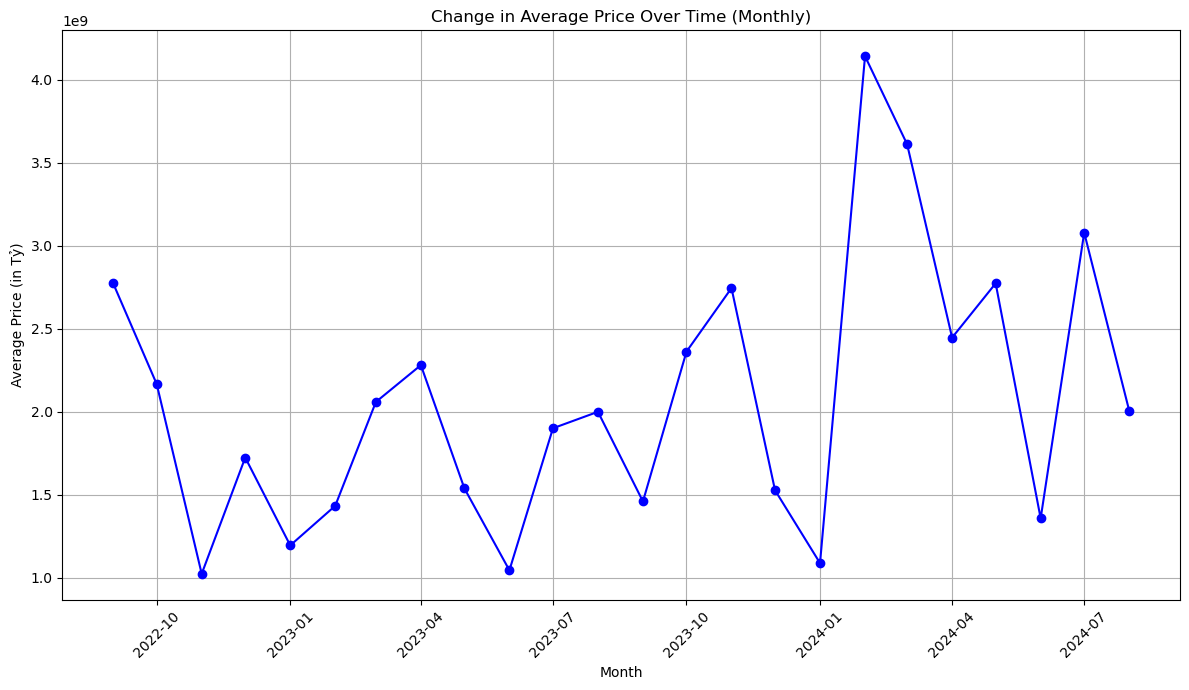

In [65]:
datedt['Month'] = datedt['Date'].dt.to_period('M')
monthly_avg_price = datedt.groupby('Month')['Price'].mean()

# Plotting the monthly average prices
plt.figure(figsize=(12, 7))
plt.plot(monthly_avg_price.index.to_timestamp(), monthly_avg_price, marker='o', color='blue')
plt.title('Change in Average Price Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Average Price (in Tỷ)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

Based on the reports on Socio Economy of Binh Duong province on the website: https://thongke.binhduong.gov.vn/
I summarize the factors or events that affected the real estate market in Bình Dương from the provided documents:

1. **Economic and Industrial Growth**: Bình Dương has seen significant foreign direct investment (FDI), particularly in industrial zones. This influx of investment has driven demand for real estate, both residential and commercial, as companies expand their operations and bring in more workers who need housing and amenities.

2. **Infrastructure Development**: Continuous improvements in infrastructure, such as roads, transportation, and utilities, have played a critical role in boosting the real estate market. Well-connected areas with better infrastructure are more attractive to investors and homebuyers.

3. **Government Policies**: The local government’s policies on urban development and support for businesses have also impacted the real estate market. Efforts to create favorable conditions for investors and streamline administrative processes have encouraged more real estate developments.

4. **Market Conditions**: The real estate market in Bình Dương has also been influenced by broader economic conditions, including demand fluctuations, which are reflected in the periodic assessments of business activities in the area.

To understand the factors influencing real estate prices in Bình Dương, we can examine several key events and data points that illustrate their impact.

**Economic and Financial Factors** play a crucial role in shaping real estate values. In 2023, Bình Dương embarked on several major infrastructure projects, including new highways and industrial zone expansions, with an investment of over VND 10 trillion (approximately USD 430 million). This significant financial commitment to infrastructure development is expected to boost real estate prices by enhancing connectivity and overall attractiveness of the region. Additionally, the General Statistics Office of Vietnam reported a 3.5% increase in the Consumer Price Index (CPI) for Bình Dương in the first half of 2024. Rising CPI often correlates with higher construction material costs, which can contribute to increased property prices.

**Banking and Financing** conditions also have a direct impact on real estate prices. In early 2024, local banks in Bình Dương reported a 12% increase in loan disbursements for real estate projects. This rise in credit availability tends to enhance purchasing power, which can drive up property prices. Furthermore, the State Bank of Vietnam's decision to lower interest rates by 0.5% in early 2024 aimed to stimulate economic growth. Lower interest rates typically make mortgages more affordable, potentially increasing demand for real estate and pushing up prices.

**Investment and Development Projects** in the region further influence real estate values. The launch of the "Bình Dương Smart City" project in late 2023, designed to be a high-tech urban development with residential and commercial spaces, is anticipated to drive property values upward due to improved amenities and infrastructure. Similarly, the introduction of new residential complexes, such as the "Eco Green City" with 2,000 apartments in 2024, can affect property values in surrounding areas by altering the supply and demand balance.

**Market Sentiment and Economic Health** are also critical factors. Bình Dương's GDP growth rate of 7.2% in 2023, surpassing the national average, reflects a robust economic environment that typically boosts real estate demand and prices. Additionally, foreign direct investment (FDI) in the region reached USD 1.5 billion in 2024, a 15% increase from the previous year. This surge in FDI signals a strong business environment, further driving real estate demand and potentially increasing prices.

**Supply and Demand Dynamics** directly impact property values. In 2024, the supply of new residential units in Bình Dương increased by 10% compared to the previous year. While an increase in supply can stabilize or reduce prices if not matched by demand, it can also indicate a response to growing market needs. Concurrently, migration trends show a 5% increase in Bình Dương's population, driven by its expanding economic opportunities and improved living conditions. This rise in population and housing demand can exert upward pressure on property prices.



In [ ]:
%pip install mercury 

In [17]:
import mercury as mr
 
# configure App properties
app = mr.App(title="Real estate data scraping notebook", description="Binh Duong province", static_notebook=True)

mercury.App

In [28]:
!mercury run

DJ CRITICAL 2024-08-18 21:16:15,987 server Listen failure: Couldn't listen on 127.0.0.1:8000: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is normally permitted.

WS_TASK 2024-08-18 21:16:15,987 Listen failure: Couldn't listen on 127.0.0.1:8000: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is normally permitted.

     _ __ ___   ___ _ __ ___ _   _ _ __ _   _ 


    | '_ ` _ \ / _ \ '__/ __| | | | '__| | | |
    | | | | | |  __/ | | (__| |_| | |  | |_| |


    |_| |_| |_|\___|_|  \___|\__,_|_|   \__, |
                                         __/ |
                                        |___/ 
        
Version: 2.4.3
The notebook scrapingrealestate.ipynb will be updated
Successfully updated a notebook (id:2)
Performing system checks...

System check identified no issues (0 silenced).
August 18, 2024 - 21:16:15
Django version 4.2.7, using settings 'server.settings'
Starting ASGI/Daphne version 4.1.2 development server at http://127.0.0.1:8000/
Quit the server with CTRL-BREAK.
